# HANDWRITTEN MATHEMATICAL EXPRESSIONS RECOGNITION
### **VIGNESH J MURALIDHARAN**
#### DECEMBER 28th, 2018

* **1. Introduction**

* **2. Data preparation**
    * 2.1 Load data
    * 2.2 Seperate data into digits and symbols
    
* **3. Principle Component Analysis and K-Nearest Neighbors**
    * 3.1 PCA for Digit
    * 3.2 KNN model for Digit
    * 3.3 Measuring PCA+KNN model performance for Digit
    * 3.4 PCA for Symbol
    * 3.5 KNN model for Symbol
    * 3.6 Measuring PCA+KNN model performance for Symbol
    
* **4. Convolutional Neural Network**
    * 4.1 Reshape data
    * 4.2 Label encoding
    * 4.3 Splitting training and validation set
    * 4.4 Define CNN model
     * 4.4.1 CNN model for digit
     * 4.4.2 CNN model for symbol
     * 4.4.3 Set the optimizer and annealer
     * 4.4.4 Data augmentation
    * 4.5 Evaluate CNN model
     * 4.5.1 Training and validation curves for digit model
     * 4.5.2 Training and validation curves for symbol model     
     * 4.5.3 Confusion matrix
       * 4.5.3.1 Confusion matrix for digit
       * 4.5.3.3 Confusion matrix for symbol
       
* **6. Predictions using CNN**

# 1. Introduction

UI DataScience Competition: Machine Learning Dataset

The purpose of this project is to grade handwritten mathematical expressions after identifying the digits and symbols in the  images. 


* **Training data:**

The training data set is an array with 80,000 rows and 577 columns. The first entry of each row is the index (or ID) of that row, and the remaining 576 entries are real numbers between 0.000 and 1.000, which represent signal intensity at the corresponding pixels. Once reshaped as a 24x24 array (that is, putting the first 24 entries in the first row, and the next 24 entries in the second row, and so on), these 576 entries represent a greyscale image of either a handwritten digit from 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 or a handwritten symbol from +, -, = with label a label from 10, 11, 12 respectively. The true label of this image is recorded in the corresponding row of the training labels.
* **Training labels:**
These are the training labels. They match with the data provided in the training data. Each represents a symbol or number.

* **Test data:**
The test data set is an array with 20,000 rows and 2881 columns. The first entry is the index (ID) of that row, and the remaining 2880 entries are real numbers between 0.000 and 1.000, representing the signal intensity at the corresponding pixel. Once reshaped as a 24x120 array, these 2880 entries represent a greyscale image of a handwritten arithmetic expression. These expressions are in one of the following forms:
$$\begin{equation} 
a+b=c \\
a-b=c\\
a=b+c\\
a=b-c
\end{equation} $$
where a, b, c are integers from 0, 1, 2, 3, 4, 5, 6, 7, 8, 9. Some of the expressions are mathematically correct, and some are incorrect. The correct expressions have a true label 1 (integer), and the incorrect expression have a true label 0 (integer).

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import timeit
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='dark', context='notebook', palette='deep')

# 2. Data preparation
## 2.1 Load data

In [14]:
# Load the data
#train set
train = pd.read_csv("F:/handwritten/train_data.csv",index_col=0)
Y_train = pd.read_csv("F:/handwritten/train_labels.csv",index_col=0)
#test set
test = pd.read_csv("F:/handwritten/test_data.csv",index_col=0)

In [15]:
# Check missing values in the data
train.isnull().any().describe()

count       576
unique        1
top       False
freq        576
dtype: object

In [16]:
test.isnull().any().describe()

count      2880
unique        1
top       False
freq       2880
dtype: object

In [17]:
# The first five row of the training data
train.head()

,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,pixel 9,pixel 10,...,pixel 567,pixel 568,pixel 569,pixel 570,pixel 571,pixel 572,pixel 573,pixel 574,pixel 575,pixel 576
index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
## total train data set with label
Total_train=pd.concat([Y_train,train], axis=1)

1     6931
7     6395
3     6333
10    6162
11    6152
12    6142
0     6122
9     6115
2     6095
6     6033
8     6020
4     5904
5     5596
Name: label, dtype: int64

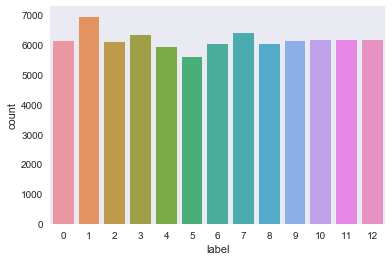

In [19]:
## digits and symbols
g = sns.countplot(Total_train['label'])

Total_train['label'].value_counts()

#### From the output above, we can see there is no missing values in the train and test dataset. 

## 2.2 Seperate data into digit and symbol

In [20]:
##seperate data into digit and symbol
digit_train=Total_train[(Total_train.label!=10)&(Total_train.label!=11)&(Total_train.label!=12)]
symbol_train=Total_train[(Total_train.label==10)|(Total_train.label==11)|(Total_train.label==12)]

In [21]:
digit_train.shape

(61544, 577)

In [22]:
symbol_train.shape

(18456, 577)

In [23]:
## digit train set 
X_digit_train=digit_train.drop(labels = ["label"],axis = 1) 
Y_digit_train=digit_train["label"]
## symbol train set
X_symbol_train=symbol_train.drop(labels = ["label"],axis = 1) 
Y_symbol_train=symbol_train["label"]-10

In [24]:
#reshape test data to (24*20000,120)
test0 = test.values.reshape(-1,120)
## divide test data to 5 parts, each part corresponse to a digit or symbol from the expression
digit_test_01 =pd.DataFrame(test0[:,0:24].reshape(20000,576))#digit
symbol_test_02=pd.DataFrame(test0[:,24:48].reshape(20000,576))#digit
digit_test_03 =pd.DataFrame(test0[:,48:72].reshape(20000,576))#digit
symbol_test_04=pd.DataFrame(test0[:,72:96].reshape(20000,576))#digit
digit_test_05 =pd.DataFrame(test0[:,96:120].reshape(20000,576))#digit

digit_test = pd.concat([digit_test_01,digit_test_03,digit_test_05],axis = 0)
symbol_test = pd.concat([symbol_test_02,symbol_test_04],axis = 0)

#test1.head()
# del train,Y_train

We have similar counts for the 10 digits.

0    6162
1    6152
2    6142
Name: label, dtype: int64

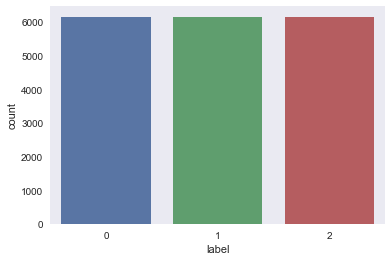

In [25]:
## symbol labels
g = sns.countplot(Y_symbol_train)

Y_symbol_train.value_counts()

We have similar counts for the 3 symbols.

C:\Users\jmvig\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


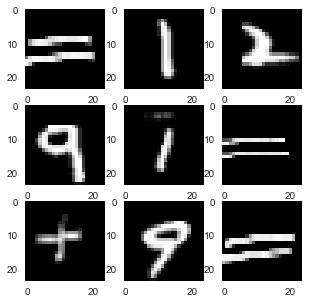

In [26]:
plt.figure(figsize=(5,5))
for digit_num in range(0,9):
    plt.subplot(3,3,digit_num+1)
    grid_data = train.iloc[digit_num+20].as_matrix().reshape(24,24)  
    plt.imshow(grid_data, interpolation = "none", cmap=plt.get_cmap('gray'))

#### Before splitting the data, we could see both digits and symbols are mixed in the same data set.

C:\Users\jmvig\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


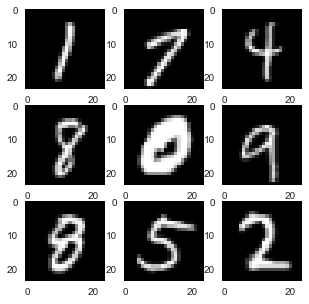

In [27]:
plt.figure(figsize=(5,5))
for digit_num in range(0,9):
    plt.subplot(3,3,digit_num+1)
    grid_data = X_digit_train.iloc[digit_num].as_matrix().reshape(24,24)  
    plt.imshow(grid_data, interpolation = "none", cmap=plt.get_cmap('gray'))

C:\Users\jmvig\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


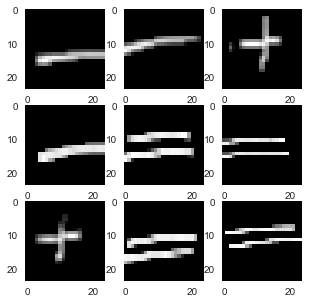

In [28]:
plt.figure(figsize=(5,5))
for digit_num in range(0,9):
    plt.subplot(3,3,digit_num+1)
    grid_data = X_symbol_train.iloc[digit_num].as_matrix().reshape(24,24)  
    plt.imshow(grid_data, interpolation = "none", cmap=plt.get_cmap('gray'))

C:\Users\jmvig\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


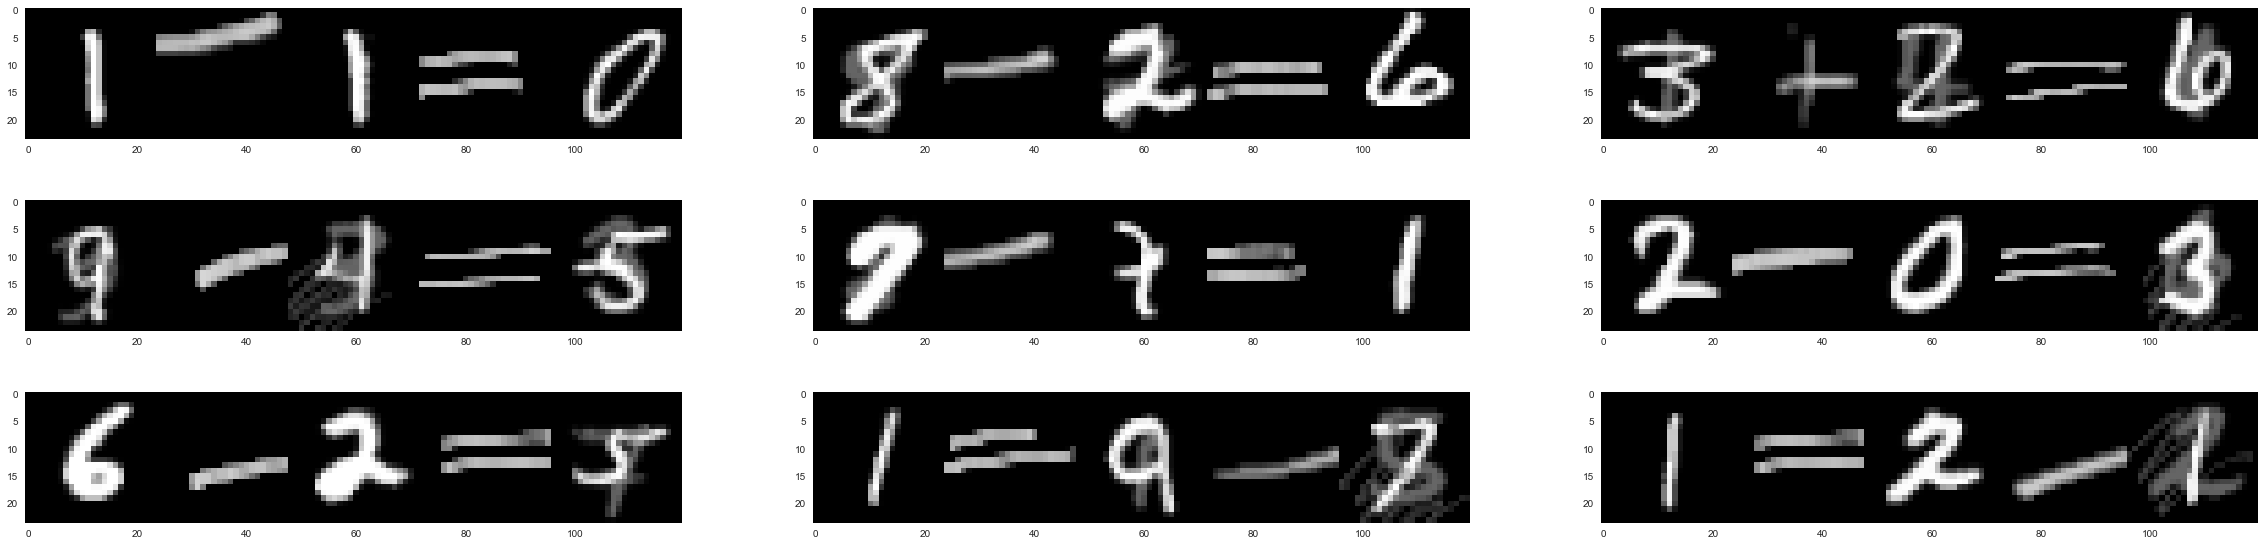

In [29]:
plt.figure(figsize=(40,10))
for digit_num in range(0,9):
    plt.subplot(3,3,digit_num+1)
    grid_data = test.iloc[digit_num].as_matrix().reshape(24,120)  
    #plt.savefig('D:/statistics/UI datascience competition/test.png')
    plt.imshow(grid_data, interpolation = "none", cmap=plt.get_cmap('gray'))

C:\Users\jmvig\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jmvig\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
C:\Users\jmvig\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\Users\jmvig\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
C:\Users\jmvig\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


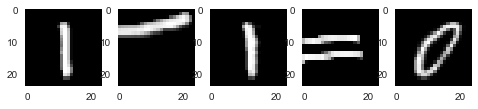

In [30]:
plt.figure(figsize=(8,8))
plt.subplot(151)
plt.imshow(digit_test_01.iloc[0].as_matrix().reshape(24,24), cmap=plt.get_cmap('gray'))
plt.subplot(152)
plt.imshow(symbol_test_02.iloc[0].as_matrix().reshape(24,24), cmap=plt.get_cmap('gray'))
plt.subplot(153)
plt.imshow(digit_test_03.iloc[0].as_matrix().reshape(24,24), cmap=plt.get_cmap('gray'))
plt.subplot(154)
plt.imshow(symbol_test_04.iloc[0].as_matrix().reshape(24,24), cmap=plt.get_cmap('gray'))
plt.subplot(155)
plt.imshow(digit_test_05.iloc[0].as_matrix().reshape(24,24), cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

# 3.Principle Component Analysis + K -Nearest Neighbors

## 3.1 PCA  for Digits

In [33]:
pca = PCA(2)  # project from 576 to 2 dimensions
PC_2= pca.fit_transform(X_digit_train)

In [34]:
plt.figure(figsize=(10, 8))
plt.scatter(PC_2[:, 0], PC_2[:, 1],
            c=Y_digit_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10),s=8)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

ValueError: Colormap spectral is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

<Figure size 720x576 with 0 Axes>

The full data is a 576-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance. Essentially, we have found the optimal stretch and rotation in 576-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner.

In [35]:
# if n_components is not set all components are kept 
pca = PCA().fit(X_digit_train)

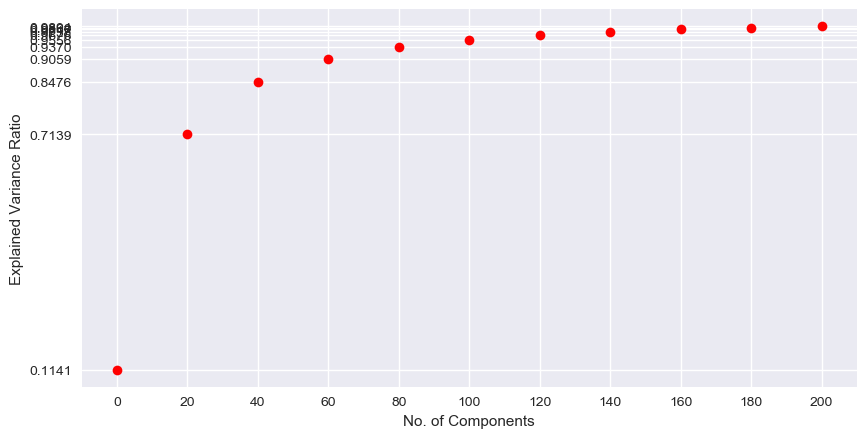

In [36]:
explained_variance = pca.explained_variance_ratio_
# ##Calculate cumulative explained ration
cum_explained_variance = [np.sum(explained_variance[:i+1]) for i in range (0, 201, 20)]
X_axis = [i for i in range(0, 201,20)]

##Plot Graph
fig = plt.figure(figsize = (10, 5), dpi=100)
plt.plot(X_axis, cum_explained_variance, 'ro')
plt.grid(True, which = 'both')
plt.yticks(cum_explained_variance)
plt.xticks(X_axis)
plt.ylabel("Explained Variance Ratio")
plt.xlabel("No. of Components")
plt.show()

Train PCA by requesting the projection preserve 90% of the variance. Common to choose number of principal components such that a percentage of the variance is retained (in this case 90%)

In [37]:
# 90% of the variance amounts to 205 principal components
pca = PCA(.90)
pca.fit(X_digit_train).n_components_

59

The idea with going from 576 components to 60 is to reduce the running time of a supervised learning algorithm (in this case k Nearest Neighbors). One of the cool things about PCA is that we can go from a compressed representation (60 components) back to an approximation of our original high dimensional data (576 components).

In [38]:
pca = PCA(n_components=60)
X_digit_train_PCs = pca.fit_transform(X_digit_train)
approximation=pca.inverse_transform(X_digit_train_PCs)

C:\Users\jmvig\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


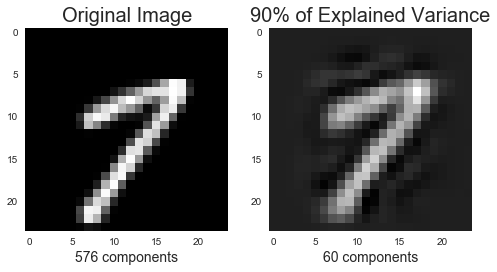

In [39]:
plt.figure(figsize=(8,4));

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(X_digit_train.iloc[1].as_matrix().reshape(24,24),
              cmap = plt.get_cmap('gray'));
plt.xlabel('576 components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 154 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[1].reshape(24,24),
              cmap = plt.get_cmap('gray'));
plt.xlabel('60 components', fontsize = 14)
plt.title('90% of Explained Variance', fontsize = 20);

## 3.1.1 K -Nearest Neighbors for digits

In [40]:
# Set the random seed
random_seed =2 # Set the random seed
# Split the symbol train and the validation set for the fitting
X_digit_train_PCs, X_digit_test_PCs, Y_digit_train_PCs, Y_digit_test_PCs = train_test_split(X_digit_train_PCs, Y_digit_train, test_size = 0.25, random_state=random_seed)

In [ ]:
#from sklearn.model_selection import cross_val_predict,cross_val_score

# creating list of K for KNN
neighbors = np.arange(1, 11)

# empty list that will hold cv scores
cv_scores = []

# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_digit_train_PCs, Y_digit_train_PCs, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MissError = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MissError.index(min(MissError))]
print ("The optimal number of neighbors is %d" % optimal_k)

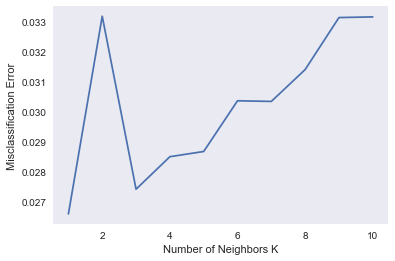

In [27]:
# Generate plot
fig = plt.figure()
# plot misclassification error vs k
plt.plot(neighbors, MissError)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

Using 10-fold-corssvalidation, the plot above shows the optimal number of neighbors is k= 1.

## 3.1.2 Measuring PCA+KNN Model Performance for digits

In [28]:
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_digit_train_PCs,Y_digit_train_PCs)
#Compute accuracy on the testing set
predict_labels = knn.predict(X_digit_test_PCs)
#Compute accuracy on the training set
train_accuracy = knn.score(X_digit_train_PCs, Y_digit_train_PCs)
#Compute accuracy on the testing set
test_accuracy = knn.score(X_digit_test_PCs, Y_digit_test_PCs)

In [29]:
print(predict_labels[0:10])

[4 4 6 5 6 9 1 0 0 2]


In [ ]:
print('Training Accuracy: %s' % train_accuracy)
print('Testing Accuracy: %s' % test_accuracy)

In [27]:
# Look at confusion matrix for digit model

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [217]:
# Encode digit labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
predict_labels  = to_categorical(predict_labels, num_classes = 10)
Y_digit_test_PCs= to_categorical(Y_digit_test_PCs, num_classes = 10)

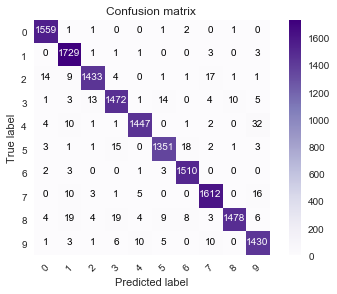

In [222]:
# Convert predictions classes to one hot vectors 
knn_pred_classes = np.argmax(predict_labels,axis = 1) 
# Convert validation observations to one hot vectors
Y_digit_true = np.argmax(Y_digit_test_PCs,axis = 1) 
# compute the confusion matrix
confusion_mtx_d = confusion_matrix(Y_digit_true, knn_pred_classes) 
# plot the confusion matrix for digit model
plot_confusion_matrix(confusion_mtx_d, classes = range(10)) 

## 3.2 PCA for Symbols

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


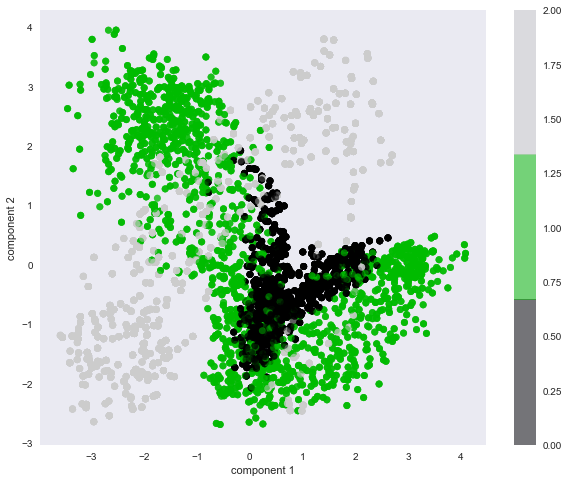

In [227]:
# project from 576 to 2 dimensions
S_PC_2= PCA(2).fit_transform(X_symbol_train)
plt.figure(figsize=(10, 8))
plt.scatter(S_PC_2[:, 0], S_PC_2[:, 1],
            c=Y_symbol_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 3))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [ ]:
# if n_components is not set all components are kept 
pca = PCA().fit(X_symbol_train)

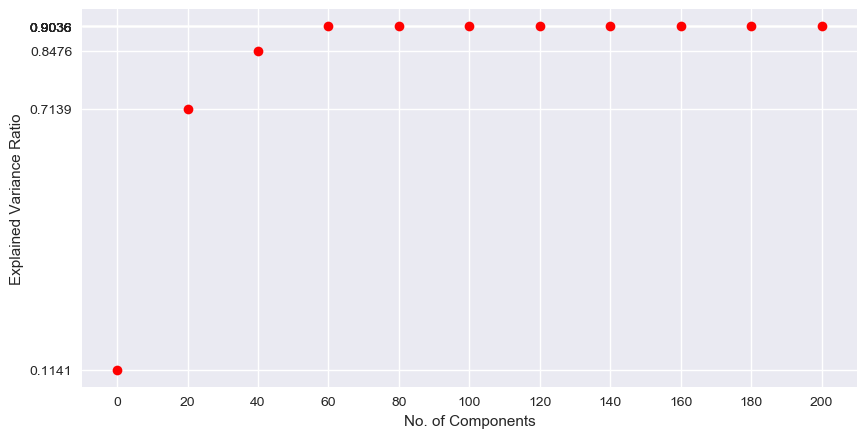

In [228]:
explained_variance = pca.explained_variance_ratio_
# ##Calculate cumulative explained ration
cum_explained_variance = [np.sum(explained_variance[:i+1]) for i in range (0, 201, 20)]
X_axis = [i for i in range(0, 201,20)]

##Plot Graph
fig = plt.figure(figsize = (10, 5), dpi=100)
plt.plot(X_axis, cum_explained_variance, 'ro')
plt.grid(True, which = 'both')
plt.yticks(cum_explained_variance)
plt.xticks(X_axis)
plt.ylabel("Explained Variance Ratio")
plt.xlabel("No. of Components")
plt.show()

Train PCA by requesting the projection preserve 90% of the variance. Common to choose number of principal components such that a percentage of the variance is retained (in this case 90%)

In [65]:
# 95% of the variance amounts to 205 principal components
pca = PCA(.90)
pca.fit(X_symbol_train).n_components_

50

The idea with going from 576 components to 50 is to reduce the running time of a supervised learning algorithm (in this case k Nearest Neighbors). One of the cool things about PCA is that we can go from a compressed representation (50 components) back to an approximation of our original high dimensional data (576 components).

In [66]:
pca = PCA(n_components=50)
X_symbol_train_PCs = pca.fit_transform(X_symbol_train)
approximation=pca.inverse_transform(X_symbol_train_PCs)

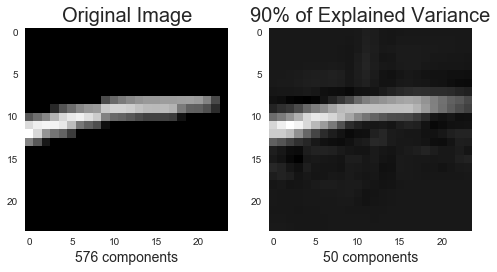

In [68]:
plt.figure(figsize=(8,4));

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(X_symbol_train.iloc[1].as_matrix().reshape(24,24),
              cmap = plt.get_cmap('gray'));
plt.xlabel('576 components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 154 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[1].reshape(24,24),
              cmap = plt.get_cmap('gray'));
plt.xlabel('50 components', fontsize = 14)
plt.title('90% of Explained Variance', fontsize = 20);

## 3.2.1 K -Nearest Neighbors for symbols

In [69]:
# Set the random seed
random_seed =2 # Set the random seed

# Split the symbol train and the validation set for the fitting
X_symbol_train_PCs, X_symbol_test_PCs, Y_symbol_train_PCs, Y_symbol_test_PCs = train_test_split(X_symbol_train_PCs, Y_symbol_train, test_size = 0.25, random_state=random_seed)

In [70]:
#from sklearn.model_selection import cross_val_predict,cross_val_score

# creating list of K for KNN
neighbors = np.arange(1, 11)

# empty list that will hold cv scores
cv_scores = []

# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_symbol_train_PCs, Y_symbol_train_PCs, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MissError = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MissError.index(min(MissError))]
print ("The optimal number of neighbors is %d" % optimal_k)

The optimal number of neighbors is 1


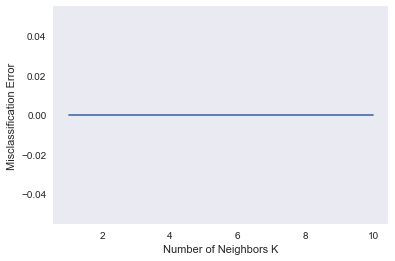

In [71]:
# Generate plot
fig = plt.figure()
# plot misclassification error vs k
plt.plot(neighbors, MissError)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

While using 10-fold cross-validation to find the optimal k, I found that there is no misclassification rate for all k (1:10), so here I just use k=1.

## 3.2.2 Measuring PCA+KNN Model Performance for Symbols

In [23]:
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_symbol_train_PCs,Y_symbol_train_PCs)
#Compute accuracy on the testing set
s_predict_labels = knn.predict(X_symbol_test_PCs)
#Compute accuracy on the training set
s_train_accuracy = knn.score(X_symbol_train_PCs, Y_symbol_train_PCs)
#Compute accuracy on the testing set
s_test_accuracy = knn.score(X_symbol_test_PCs, Y_symbol_test_PCs)

In [24]:
print('Training Accuracy: %s' % s_train_accuracy)
print('Testing Accuracy: %s' % s_test_accuracy)

Training Accuracy: 1.0
Testing Accuracy: 1.0


In [25]:
# Encode digit labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
s_predict_labels  = to_categorical(s_predict_labels, num_classes = 10)
Y_symbol_test_PCs= to_categorical(Y_symbol_test_PCs, num_classes = 10)

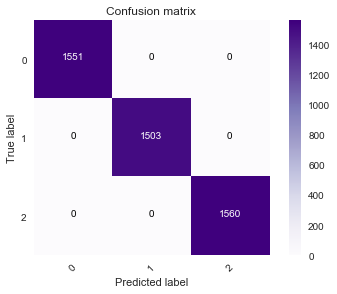

In [28]:
# Convert predictions classes to one hot vectors 
knn_pred_classes_s = np.argmax(s_predict_labels,axis = 1) 
# Convert validation observations to one hot vectors
Y_symbol_true = np.argmax(Y_symbol_test_PCs,axis = 1) 
# compute the confusion matrix
confusion_mtx_s = confusion_matrix(Y_symbol_true, knn_pred_classes_s) 
# plot the confusion matrix for digit model
plot_confusion_matrix(confusion_mtx_s, classes = range(3)) 

The confusion matrix also shows that no misclaffication for symbols while using KNN to validate the symbol model.

# 4. Convolutional Neural Network

This is a Sequential Convolutional Neural Network for handwritten mathematical expressions recognition trained on UI Data Science Competition-Machine Learning Dataset. I choosed to build it with keras API (Tensorflow backend) which is very intuitive. Firstly, I will prepare the data (handwritten digits images) then i will focus on the CNN modeling and evaluation.

I achieved 99.6% of accuracy with this CNN trained in about 3 hours on a single CPU. 

## 4.1 Reshape Data

In [13]:
# Reshape train image in 3 dimensions (height = 24px, width = 24px , canal = 1)
X_digit_train  = X_digit_train.values.reshape (-1,24,24,1) #(height = 24px, width = 24px , canal = 1)
X_symbol_train = X_symbol_train.values.reshape (-1,24,24,1) #(height = 24px, width = 24px , canal = 1)

#X_symbol_train.values.reshape 

#equation_test  = test.values.reshape(-1,24,120,1) #(height = 24px, width = 120px , canal = 1)
#reshape test data to (24*20000,120)
test0 = test.values.reshape(-1,120)
## divide test data to 5 parts, each part corresponse to a digit or symbol from the expression
digit_test1  = test0[:,0:24]  #digit
symbol_test2 = test0[:,24:48] #symbol
digit_test3  = test0[:,48:72]  #digit
symbol_test4 = test0[:,72:96] #simbol
digit_test5  = test0[:,96:120] #digit

## Reshape test image in 3 dimensions (height = 24px, width = 24px , canal = 1)
#digit_test1  = digit_test1.values.reshape(-1,24,24,1) #(height = 24px, width = 24px , canal = 1)
#symbol_test2 = symbol_test2.values.reshape(-1,24,24,1) #(height = 24px, width = 24px , canal = 1)
#digit_test3  = digit_test3.values.reshape(-1,24,24,1) #(height = 24px, width = 24px , canal = 1)
#symbol_test4 = symbol_test4.values.reshape(-1,24,24,1) #(height = 24px, width = 24px , canal = 1)
#digit_test5  = digit_test5.values.reshape(-1,24,24,1) #(height = 24px, width = 24px , canal = 1)

##
digit_test1  = digit_test1.reshape(-1,24,24,1) #(height = 24px, width = 24px , canal = 1)
symbol_test2 = symbol_test2.reshape(-1,24,24,1) #(height = 24px, width = 24px , canal = 1)
digit_test3  = digit_test3.reshape(-1,24,24,1) #(height = 24px, width = 24px , canal = 1)
symbol_test4 = symbol_test4.reshape(-1,24,24,1) #(height = 24px, width = 24px , canal = 1)
digit_test5  = digit_test5.reshape(-1,24,24,1) #(height = 24px, width = 24px , canal = 1)

Train images (24px x 24px) has been stock into pandas.Dataframe as 1D vectors of 576 values. I reshape all data to 24x24x1 3D matrices. 

Test images (24px x 24px) has been stock into pandas.Dataframe as 1D vectors of 576 values.I reshape all data to 24x24x1 3D matrices. 

Keras requires an extra dimension in the end which correspond to channels. The images are gray scaled so it use only one channel.

## 4.2 Label encoding

In [14]:
# Encode digit labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_digit_train  = to_categorical(Y_digit_train, num_classes = 10)

In [15]:
Y_digit_train.shape

(61544, 10)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0,0,0,0]).

In [16]:
# Encode symbol labels to one hot vectors (ex : 2 -> [0,0,1])
Y_symbol_train = to_categorical(Y_symbol_train, num_classes = 3)

Labels are 10 digits  symbol from +, -, = with label a label from 10, 11, 12.We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1]).

## 4.3 Split training and valdiation set

In [17]:
# Set the random seed
random_seed = 2
# Split the digit train and the validation set for the fitting
X_digit_train, X_digit_val, Y_digit_train, Y_digit_val = train_test_split(X_digit_train, Y_digit_train, test_size = 0.1, random_state=random_seed)
# Split the symbol train and the validation set for the fitting
X_symbol_train, X_symbol_val, Y_symbol_train, Y_symbol_val = train_test_split(X_symbol_train, Y_symbol_train, test_size = 0.1, random_state=random_seed)

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model. Since we have training images of balanced labels, a random split of the train set doesn't cause some labels to be over represented in the validation set. 

In [18]:
print(X_digit_train.shape)

(55389, 24, 24, 1)


## 4.4 Define CNN model

Convolutional Neural Networks are multi-layer neural networks, with many hidden layers that can sequentially learn more complex features from the raw input image

I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It will extract features from input image using small squares of input data. For each sub-region, the layer performs a set of mathematical operations to produce a single value in the output feature map. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time). The higher the pooling dimension is, the more important the downsampling is. 

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting. 

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network. 

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end I used the features in two fully-connected (Dense) layers which is just an artificial neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax") or Dense(3,activation="softmax")) the net outputs distribution of probability of each class.

### 4.4.1 CNN model for digit

In [19]:
# Set the CNN model for digit
# the CNN architechture is Input -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Output

model_d = Sequential()

model_d.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (24,24,1)))
model_d.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model_d.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_d.add(Dropout(0.25))


model_d.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model_d.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model_d.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_d.add(Dropout(0.25))


model_d.add(Flatten())
model_d.add(Dense(512, activation = "relu"))
model_d.add(Dropout(0.44))
model_d.add(Dense(10, activation = "softmax"))

### 4.4.2 CNN model for symbol

In [20]:
# Set the CNN model for symbol
# the CNN architechture is Input -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Output

model_s = Sequential()

model_s.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (24,24,1)))
model_s.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model_s.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_s.add(Dropout(0.25))


model_s.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model_s.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model_s.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_s.add(Dropout(0.25))


model_s.add(Flatten())
model_s.add(Dense(256, activation = "relu"))
model_s.add(Dropout(0.5))
model_s.add(Dense(3, activation = "softmax"))

## 4.4.3 Set the optimizer and annealer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss. 

I choosed RMSprop (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate.

We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

The metric function "accuracy" is used is to evaluate the performance our model.

This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [21]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [22]:
# Compile the digit model
model_d.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [23]:
# Compile the symbol model
model_s.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

<img src="http://img1.imagilive.com/0717/learningrates.jpg"> </img>

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function. 

To keep the advantage of the fast computation time with a high LR, I decreased the LR dynamically every epoch depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, I choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [24]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [25]:
epochs =30  # Turn epochs to 30 to get 0.9953 accuracy
batch_size = 128

## 4.4.4 Data augmentation 

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make the existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. 

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [26]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally by 10% of the width (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically by 10% of the height (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_digit_train)  #data augmentation for digit model
datagen.fit(X_symbol_train) #data augmentation for symbol model

In [27]:
X_digit_train.shape[0] // batch_size

432

In [28]:
X_symbol_train.shape[0] // batch_size

129

In [29]:

start = timeit.default_timer()

# Fit the digit model
model_d_fit = model_d.fit_generator(datagen.flow(X_digit_train,Y_digit_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_digit_val,Y_digit_val),
                              verbose = 2, steps_per_epoch=X_digit_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

# Fit the symbol model
model_s_fit = model_s.fit_generator(datagen.flow(X_symbol_train,Y_symbol_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_symbol_val,Y_symbol_val),
                              verbose = 2, steps_per_epoch=X_symbol_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

#Your statements here

stop = timeit.default_timer()

print (stop - start )

Epoch 1/30
 - 263s - loss: 0.3975 - acc: 0.8721 - val_loss: 0.0740 - val_acc: 0.9753
Epoch 2/30
 - 260s - loss: 0.1182 - acc: 0.9638 - val_loss: 0.0355 - val_acc: 0.9898
Epoch 3/30
 - 247s - loss: 0.0852 - acc: 0.9749 - val_loss: 0.0593 - val_acc: 0.9818
Epoch 4/30
 - 248s - loss: 0.0707 - acc: 0.9790 - val_loss: 0.0329 - val_acc: 0.9903
Epoch 5/30
 - 259s - loss: 0.0640 - acc: 0.9811 - val_loss: 0.0355 - val_acc: 0.9909
Epoch 6/30
 - 264s - loss: 0.0589 - acc: 0.9823 - val_loss: 0.0502 - val_acc: 0.9862
Epoch 7/30
 - 245s - loss: 0.0564 - acc: 0.9825 - val_loss: 0.0292 - val_acc: 0.9924
Epoch 8/30
 - 259s - loss: 0.0525 - acc: 0.9844 - val_loss: 0.0319 - val_acc: 0.9920
Epoch 9/30
 - 257s - loss: 0.0506 - acc: 0.9852 - val_loss: 0.0286 - val_acc: 0.9922
Epoch 10/30
 - 252s - loss: 0.0495 - acc: 0.9853 - val_loss: 0.0363 - val_acc: 0.9911

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 11/30
 - 281s - loss: 0.0393 - acc: 0.9882 - val_loss: 0.0246 

The results above show the training and validation accuracy when epochs=30. 

# 4.5 Evaluate the CNN model

### 4.5.1 Training and validation curves for digit model

The code below is for plotting loss and accuracy curves for training and validation. Since, I set epochs = 5 on this notebook .
I'll show the training and validation curves I obtained from the model I build with 30 epochs.

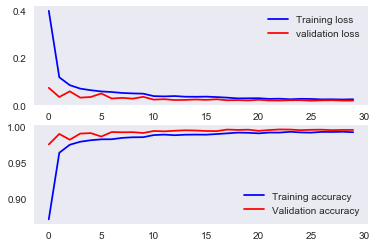

In [30]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(model_d_fit.history['loss'], color='b', label="Training loss")
ax[0].plot(model_d_fit.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(model_d_fit.history['acc'], color='b', label="Training accuracy")
ax[1].plot(model_d_fit.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### 4.5.2 Training and validation curves for symbol model

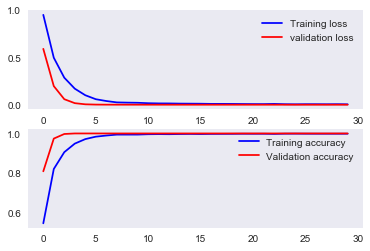

In [33]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(model_s_fit.history['loss'], color='b', label="Training loss")
ax[0].plot(model_s_fit.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(model_s_fit.history['acc'], color='b', label="Training accuracy")
ax[1].plot(model_s_fit.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### 4.5.3 Confusion matrix

Confusion matrix can be very helpfull to see your model drawbacks.

I plot the confusion matrix of the validation results.

#### 4.5.3.1 Confusion matrix for digit model

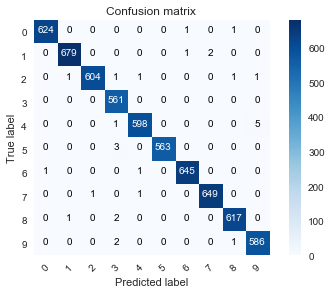

In [31]:
# Look at confusion matrix for digit model

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_digit_pred = model_d.predict(X_digit_val)
# Convert predictions classes to one hot vectors 
Y_digit_pred_classes = np.argmax(Y_digit_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_digit_true = np.argmax(Y_digit_val,axis = 1) 
# compute the confusion matrix
confusion_mtx_d = confusion_matrix(Y_digit_true, Y_digit_pred_classes) 
# plot the confusion matrix for digit model
plot_confusion_matrix(confusion_mtx_d, classes = range(10)) 

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set (8000 images).

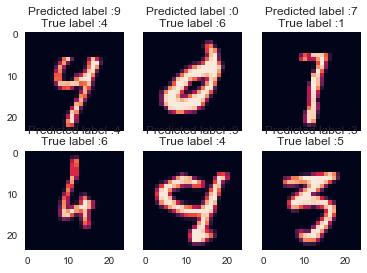

In [32]:
# Display some error results for digit model

# Errors are difference between predicted labels and true labels
digit_errors = (Y_digit_pred_classes - Y_digit_true != 0)

Y_digit_pred_classes_errors = Y_digit_pred_classes[digit_errors]
Y_digit_pred_errors = Y_digit_pred[digit_errors]
Y_digit_true_errors = Y_digit_true[digit_errors]
X_digit_val_errors  = X_digit_val[digit_errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((24,24)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_digit_pred_errors_prob = np.max(Y_digit_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
digit_true_prob_errors = np.diagonal(np.take(Y_digit_pred_errors, Y_digit_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
digit_delta_pred_true_errors = Y_digit_pred_errors_prob - digit_true_prob_errors

# Sorted list of the delta prob errors
digit_sorted_dela_errors = np.argsort(digit_delta_pred_true_errors)

# Top 6 errors 
digit_most_important_errors = digit_sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(digit_most_important_errors, X_digit_val_errors, Y_digit_pred_classes_errors, Y_digit_true_errors)

The most important errors are also the most intrigous. For those six case, the model is not ridiculous.

### 4.5.3.2 Confusion matrix for symbol model

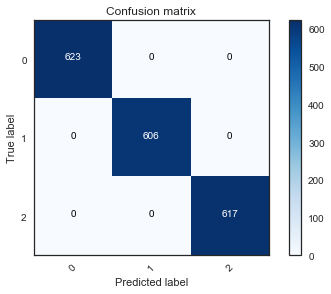

In [44]:
# Look at confusion matrix  for symbol model
# Predict the values from the validation dataset
Y_symbol_pred = model_s.predict(X_symbol_val)
# Convert predictions classes to one hot vectors 
Y_symbol_pred_classes = np.argmax(Y_symbol_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_symbol_true = np.argmax(Y_symbol_val,axis = 1) 
# compute the confusion matrix
confusion_mtx_s = confusion_matrix(Y_symbol_true, Y_symbol_pred_classes) 
# plot the confusion matrix for symbol model
plot_confusion_matrix(confusion_mtx_s, classes = range(3)) 

Here we can see that our CNN performs perfect on all symbols without errors.

# 4.6 Predictions using CNN

In [45]:
# predict results
result_digit_1  = model_d.predict(digit_test1)
result_symbol_2 = model_s.predict(symbol_test2)
result_digit_3  = model_d.predict(digit_test3)
result_symbol_4 = model_s.predict(symbol_test4)
result_digit_5  = model_d.predict(digit_test5)

# select the indix with the maximum probability
result_digit_1  = np.argmax(result_digit_1 ,axis = 1)
result_symbol_2  = np.argmax(result_symbol_2 ,axis = 1)
result_digit_3   = np.argmax(result_digit_3 ,axis = 1)
result_symbol_4  = np.argmax(result_symbol_4 ,axis = 1)
result_digit_5   = np.argmax(result_digit_5 ,axis = 1)

In [46]:
# label the results
result_digit_1   = pd.Series(result_digit_1,name="label1")
result_symbol_2  = pd.Series(result_symbol_2,name="label2")
result_digit_3   = pd.Series(result_digit_3,name="label3")
result_symbol_4  = pd.Series(result_symbol_4,name="label4")
result_digit_5   = pd.Series(result_digit_5,name="label5")

In [57]:
output = pd.concat([result_digit_1,result_symbol_2,result_digit_3,result_symbol_4,result_digit_5],axis = 1)

In [58]:
output.shape[0]

20000

In [59]:
output.head()

,Label1,Label2,Label3,Label4,Label5
0,1,1,1,2,0
1,8,1,2,2,6
2,3,0,2,2,6
3,9,1,4,2,5
4,7,1,7,2,1


In [62]:
length = output.shape[0]
length 

20000

In [63]:
length = output.shape[0]
result= np.zeros(length)
for i in range(length):
        if (((output.iloc[i,][1]==2)&(output.iloc[i,][3]==0)&(output.iloc[i,][0]==(output.iloc[i,][2]+output.iloc[i,][4])))|
           ((output.iloc[i,][1]==2)&(output.iloc[i,][3]==1)&(output.iloc[i,][0]==(output.iloc[i,][2]-output.iloc[i,][4])))|
           ((output.iloc[i,][3]==2)&(output.iloc[i,][1]==0)&((output.iloc[i,][0]+output.iloc[i,][2])==output.iloc[i,][4]))|
            ((output.iloc[i,][3]==2)&(output.iloc[i,][1]==1)&((output.iloc[i,][0]-output.iloc[i,][2])==output.iloc[i,][4]))):
                result[i]=1                                       
        else:   result[i]=0                                            

In [48]:
result   = pd.Series(result,name="label")

In [66]:
# result = pd.Series(map(lambda x:[x], result)).apply(lambda x:x[0],name="Label")

In [66]:
submission = pd.concat([pd.Series(range(20000),name = "index"),result],axis = 1)